In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 80

ng =10

ng_adju = (/ 0 /) 

ng_refs = (/ 4 , 6 /) 

nref =2

nv = 200

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

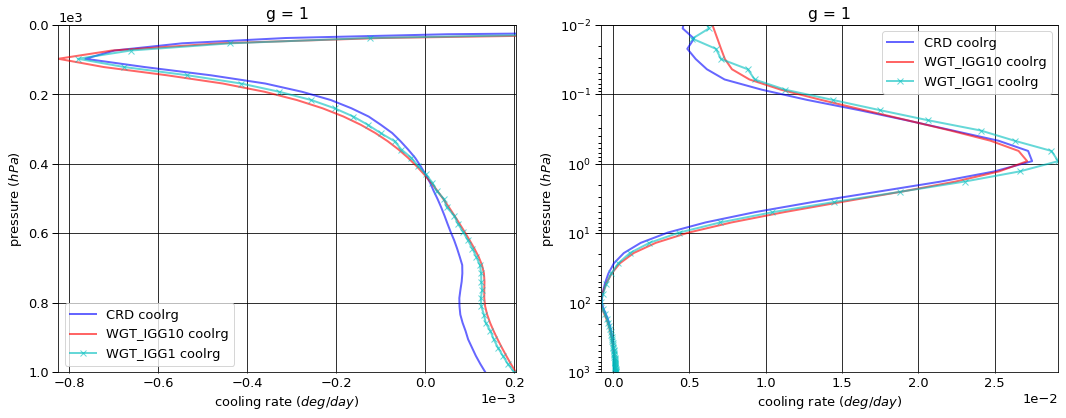

# Figure: cooling rate g-group 2

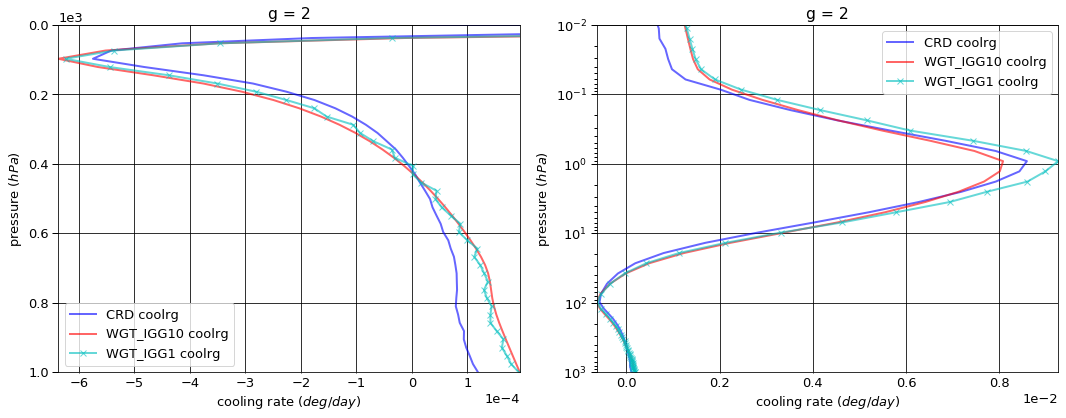

# Figure: cooling rate g-group 3

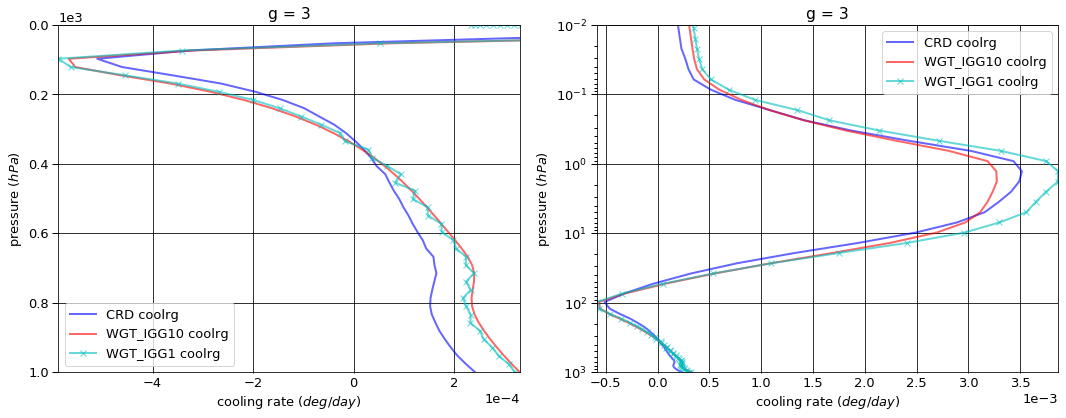

# Figure: cooling rate g-group 4

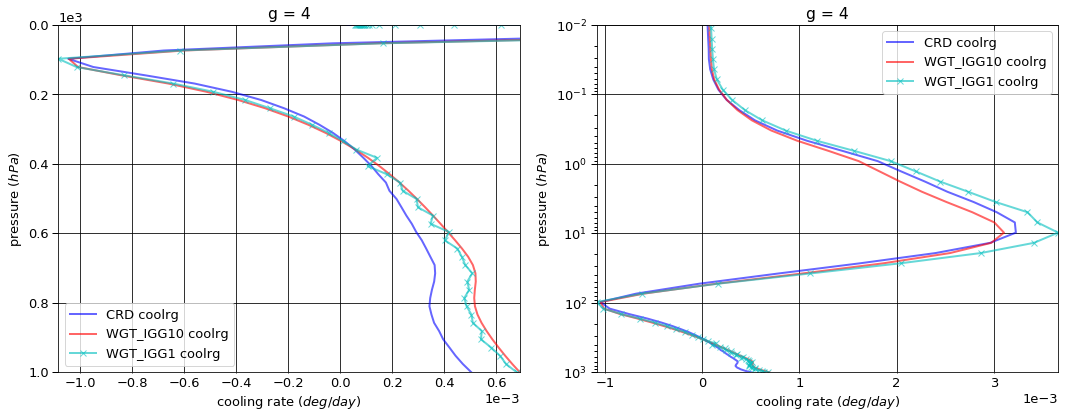

# Figure: cooling rate g-group 5

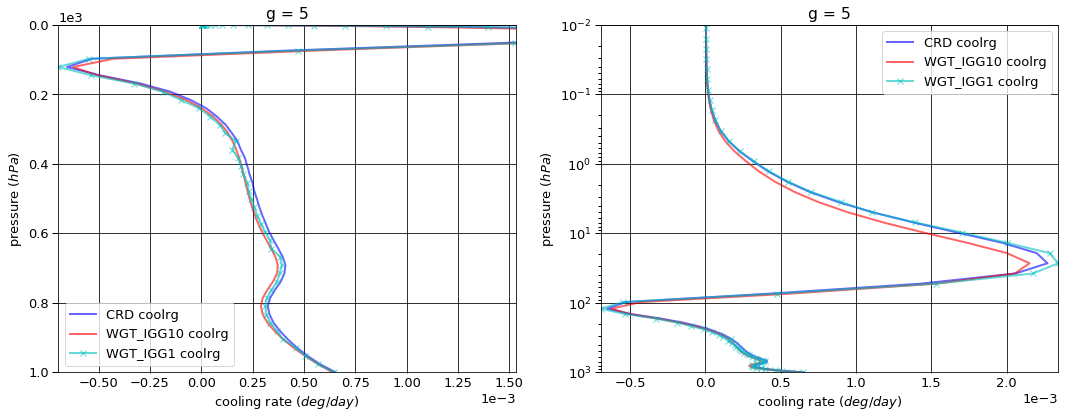

# Figure: cooling rate g-group 6

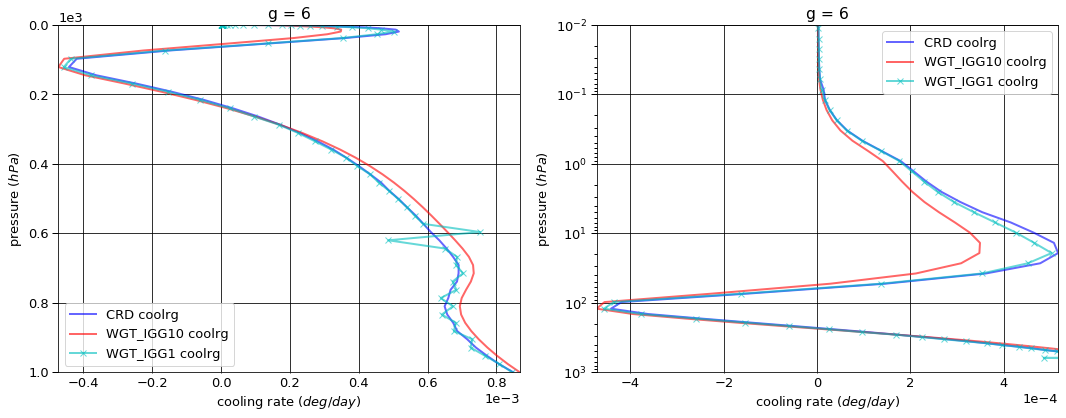

# Figure: cooling rate g-group 7

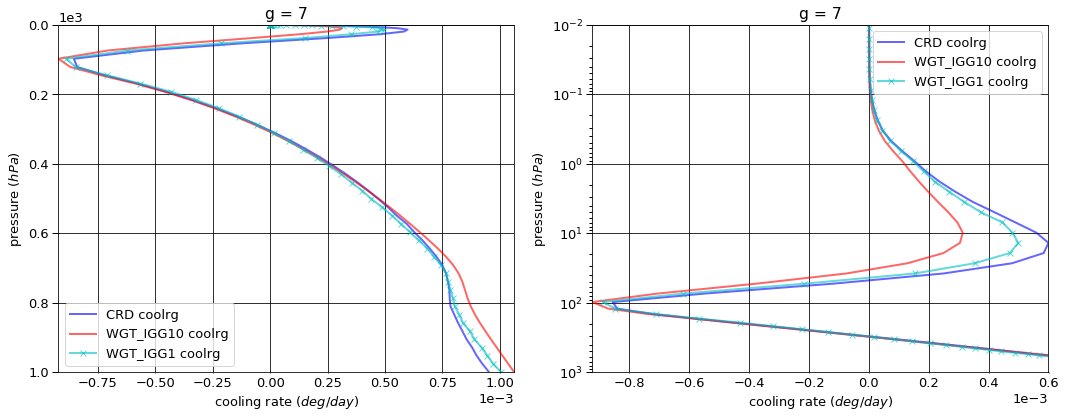

# Figure: cooling rate g-group 8

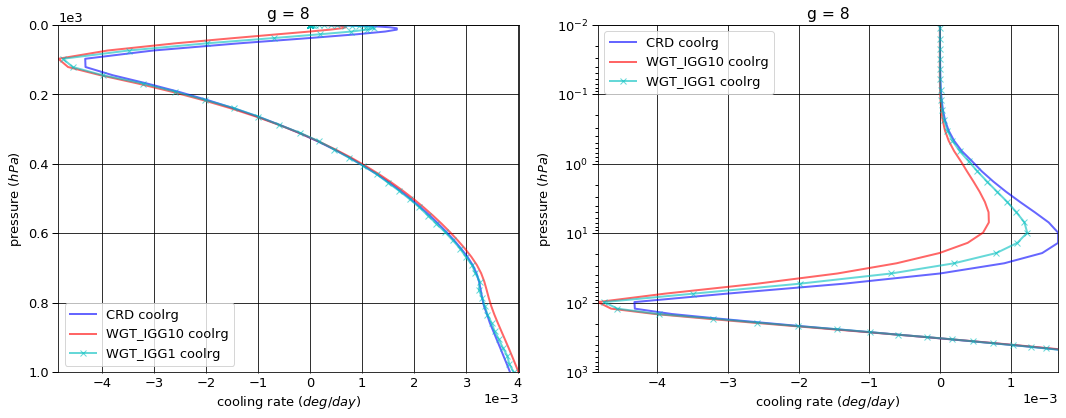

# Figure: cooling rate g-group 9

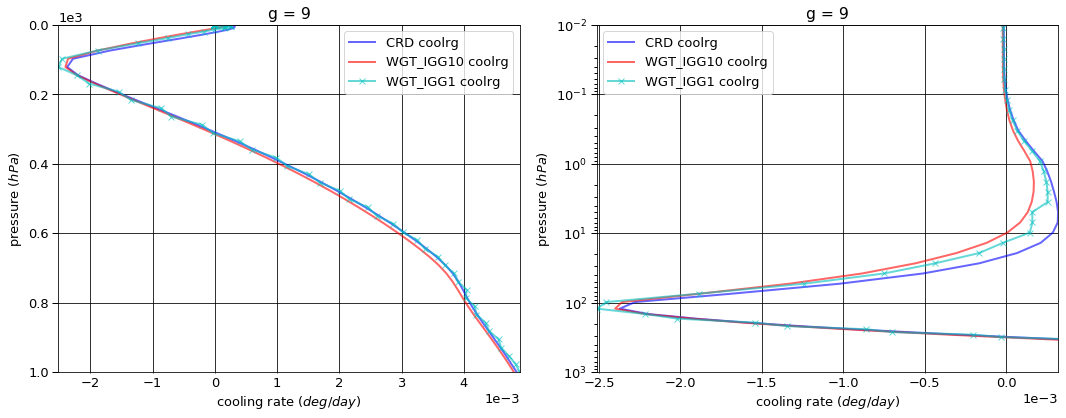

# Figure: cooling rate g-group 10

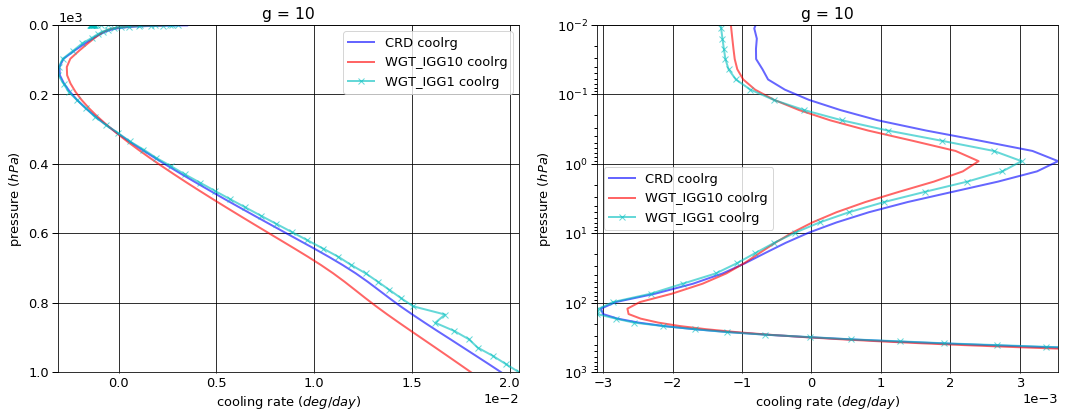

# Figure: cooling rate g-group total

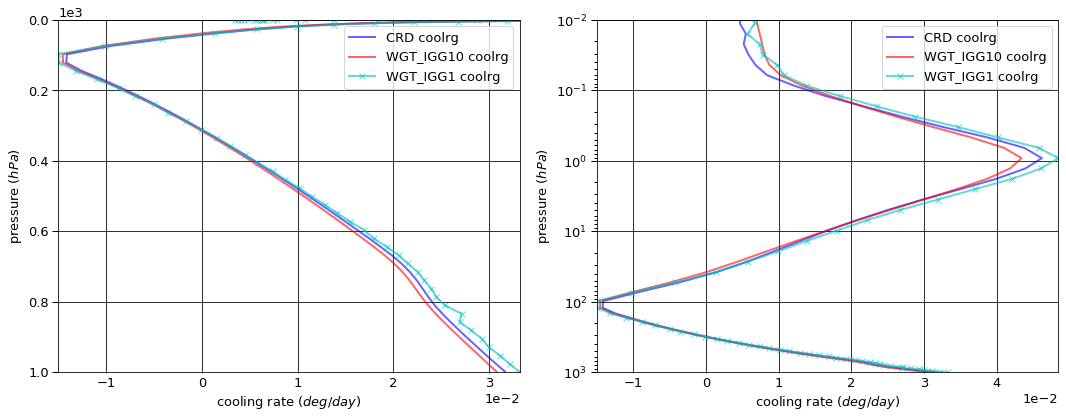

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.023416  0.000000  -0.023416
   1013.0   76     -0.045793  0.030163  -0.015630
2  0.0      1      -0.024944  0.000000  -0.024944
   1013.0   76     -0.045778  0.024114  -0.021664
3  0.0      1      -0.038174  0.000000  -0.038174
   1013.0   76     -0.069891  0.042632  -0.027259
4  0.0      1      -0.072908  0.000000  -0.072908
   1013.0   76     -0.139789  0.086454  -0.053335
5  0.0      1      -0.053581  0.000000  -0.053581
   1013.0   76     -0.147073  0.130819  -0.016254
6  0.0      1      -0.085227  0.000000  -0.085227
   1013.0   76     -0.156717  0.119675  -0.037042
7  0.0      1      -0.135210  0.000000  -0.135210
   1013.0   76     -0.207302  0.112355  -0.094947
8  0.0      1      -1.078801  0.000000  -1.078801
   1013.0   76     -1.411971  0.473944  -0.938026
9  0.0      1      -1.990868  0.000000  -1.990868
   1013.0   76     -2.230766  0.452319  -1.778447
10 0.0      1     -33.583873  0.000000 -33.583873
   1013.0   76    -34.036656  1.226340 -32.810316


WGT_IGG10


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.020853  0.000000  -0.020853
   1013.0   76     -0.045793  0.037332  -0.008460
2  0.0      1      -0.020277  0.000000  -0.020277
   1013.0   76     -0.045778  0.031791  -0.013987
3  0.0      1      -0.028661  0.000000  -0.028661
   1013.0   76     -0.069891  0.056499  -0.013392
4  0.0      1      -0.059552  0.000000  -0.059552
   1013.0   76     -0.139789  0.109183  -0.030606
5  0.0      1      -0.048526  0.000000  -0.048526
   1013.0   76     -0.147073  0.133328  -0.013745
6  0.0      1      -0.081745  0.000000  -0.081745
   1013.0   76     -0.156717  0.124423  -0.032293
7  0.0      1      -0.131535  0.000000  -0.131535
   1013.0   76     -0.207302  0.116811  -0.090491
8  0.0      1      -1.071040  0.000000  -1.071040
   1013.0   76     -1.411971  0.473130  -0.938840
9  0.0      1      -2.004350  0.000000  -2.004350
   1013.0   76     -2.230766  0.427706  -1.803060
10 0.0      1     -33.645434  0.000000 -33.645434
   1013.0   76    -34.036656  1.094082 -32.942574


WGT_IGG1


flug      fldg      fnetg
g  pressure level                                
1  0.0      1      -0.021468  0.000000  -0.021468
   1013.0   76     -0.045793  0.036634  -0.009158
2  0.0      1      -0.021413  0.000000  -0.021413
   1013.0   76     -0.045778  0.031139  -0.014639
3  0.0      1      -0.030240  0.000000  -0.030240
   1013.0   76     -0.069891  0.055148  -0.014743
4  0.0      1      -0.062525  0.000000  -0.062525
   1013.0   76     -0.139789  0.106379  -0.033410
5  0.0      1      -0.050973  0.000000  -0.050973
   1013.0   76     -0.147073  0.131503  -0.015570
6  0.0      1      -0.083447  0.000000  -0.083447
   1013.0   76     -0.156717  0.120846  -0.035870
7  0.0      1      -0.132115  0.000000  -0.132115
   1013.0   76     -0.207302  0.114752  -0.092550
8  0.0      1      -1.061744  0.000000  -1.061744
   1013.0   76     -1.411971  0.482631  -0.929340
9  0.0      1      -1.984347  0.000000  -1.984347
   1013.0   76     -2.230766  0.456789  -1.773977
10 0.0      1     -33.577232  0.000000 -33.577232
   1013.0   76    -34.036656  1.272092 -32.764564


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.002562  0.000000  0.002562
   1013.0   76     0.000000  0.007170  0.007170
2  0.0      1      0.004667  0.000000  0.004667
   1013.0   76     0.000000  0.007677  0.007677
3  0.0      1      0.009513  0.000000  0.009513
   1013.0   76     0.000000  0.013867  0.013867
4  0.0      1      0.013356  0.000000  0.013356
   1013.0   76     0.000000  0.022729  0.022729
5  0.0      1      0.005055  0.000000  0.005055
   1013.0   76     0.000000  0.002509  0.002509
6  0.0      1      0.003483  0.000000  0.003483
   1013.0   76     0.000000  0.004748  0.004748
7  0.0      1      0.003676  0.000000  0.003676
   1013.0   76     0.000000  0.004456  0.004456
8  0.0      1      0.007761  0.000000  0.007761
   1013.0   76     0.000000 -0.000814 -0.000814
9  0.0      1     -0.013482  0.000000 -0.013482
   1013.0   76     0.000000 -0.024613 -0.024613
10 0.0      1     -0.061561  0.000000 -0.061561
   1013.0   76     0.000000 -0.132258 -0.132258


WGT_IGG1 - CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.001948  0.000000  0.001948
   1013.0   76     0.000000  0.006472  0.006472
2  0.0      1      0.003531  0.000000  0.003531
   1013.0   76     0.000000  0.007025  0.007025
3  0.0      1      0.007934  0.000000  0.007934
   1013.0   76     0.000000  0.012516  0.012516
4  0.0      1      0.010382  0.000000  0.010382
   1013.0   76     0.000000  0.019925  0.019925
5  0.0      1      0.002609  0.000000  0.002609
   1013.0   76     0.000000  0.000684  0.000684
6  0.0      1      0.001780  0.000000  0.001780
   1013.0   76     0.000000  0.001171  0.001171
7  0.0      1      0.003095  0.000000  0.003095
   1013.0   76     0.000000  0.002398  0.002398
8  0.0      1      0.017058  0.000000  0.017058
   1013.0   76     0.000000  0.008687  0.008687
9  0.0      1      0.006521  0.000000  0.006521
   1013.0   76     0.000000  0.004470  0.004470
10 0.0      1      0.006641  0.000000  0.006641
   1013.0   76     0.000000  0.045752  0.045752

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      2.785821e-03
   1001.112500 75     1.351611e-04
2  0.000312    1      3.092709e-03
   1001.112500 75     1.189885e-04
3  0.000312    1      9.945079e-05
   1001.112500 75     2.420295e-04
4  0.000312    1      2.828616e-05
   1001.112500 75     5.050637e-04
5  0.000312    1      1.235099e-06
   1001.112500 75     6.529444e-04
6  0.000312    1      1.355966e-06
   1001.112500 75     8.489691e-04
7  0.000312    1     -1.926558e-09
   1001.112500 75     9.537721e-04
8  0.000312    1     -2.026469e-06
   1001.112500 75     3.851254e-03
9  0.000312    1     -1.913473e-05
   1001.112500 75     4.851145e-03
10 0.000312    1     -9.789239e-04
   1001.112500 75     1.957330e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      4.521957e-03
   1001.112500 75     2.036333e-04
2  0.000312    1      8.623432e-04
   1001.112500 75     1.942800e-04
3  0.000312    1      2.121755e-04
   1001.112500 75     3.309024e-04
4  0.000312    1      4.739178e-05
   1001.112500 75     6.917577e-04
5  0.000312    1      1.440367e-06
   1001.112500 75     6.388062e-04
6  0.000312    1      6.657029e-07
   1001.112500 75     8.678975e-04
7  0.000312    1     -5.698562e-07
   1001.112500 75     1.063042e-03
8  0.000312    1     -2.530481e-06
   1001.112500 75     4.014555e-03
9  0.000312    1     -2.402162e-05
   1001.112500 75     4.806035e-03
10 0.000312    1     -1.268473e-03
   1001.112500 75     1.803018e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      3.843077e-03
   1001.112500 75     2.002106e-04
2  0.000312    1      8.154552e-04
   1001.112500 75     1.924495e-04
3  0.000312    1      2.336069e-04
   1001.112500 75     3.211073e-04
4  0.000312    1      5.867978e-05
   1001.112500 75     6.795988e-04
5  0.000312    1      1.673983e-06
   1001.112500 75     6.453484e-04
6  0.000312    1      1.414371e-06
   1001.112500 75     8.455816e-04
7  0.000312    1      1.204226e-07
   1001.112500 75     1.007004e-03
8  0.000312    1     -1.489551e-06
   1001.112500 75     3.922265e-03
9  0.000312    1     -2.103236e-05
   1001.112500 75     4.899122e-03
10 0.000312    1     -1.441518e-03
   1001.112500 75     2.048925e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.736135e-03
   1001.112500 75     6.847222e-05
2  0.000312    1     -2.230365e-03
   1001.112500 75     7.529148e-05
3  0.000312    1      1.127247e-04
   1001.112500 75     8.887293e-05
4  0.000312    1      1.910561e-05
   1001.112500 75     1.866940e-04
5  0.000312    1      2.052683e-07
   1001.112500 75    -1.413822e-05
6  0.000312    1     -6.902628e-07
   1001.112500 75     1.892843e-05
7  0.000312    1     -5.679297e-07
   1001.112500 75     1.092702e-04
8  0.000312    1     -5.040121e-07
   1001.112500 75     1.633005e-04
9  0.000312    1     -4.886891e-06
   1001.112500 75    -4.511070e-05
10 0.000312    1     -2.895487e-04
   1001.112500 75    -1.543120e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.057256e-03
   1001.112500 75     6.504953e-05
2  0.000312    1     -2.277254e-03
   1001.112500 75     7.346094e-05
3  0.000312    1      1.341561e-04
   1001.112500 75     7.907781e-05
4  0.000312    1      3.039362e-05
   1001.112500 75     1.745351e-04
5  0.000312    1      4.388842e-07
   1001.112500 75    -7.596050e-06
6  0.000312    1      5.840540e-08
   1001.112500 75    -3.387430e-06
7  0.000312    1      1.223492e-07
   1001.112500 75     5.323218e-05
8  0.000312    1      5.369175e-07
   1001.112500 75     7.101040e-05
9  0.000312    1     -1.897636e-06
   1001.112500 75     4.797640e-05
10 0.000312    1     -4.625938e-04
   1001.112500 75     9.159510e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-37.087003,0.000000,-37.087003
1013.0,76,-38.491734,2.698814,-35.792920



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-37.111972,0.000000,-37.111972
1013.0,76,-38.491734,2.604286,-35.887448



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-37.025503,0.000000,-37.025503
1013.0,76,-38.491734,2.807913,-35.683821



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.024969,0.000000,-0.024969
1013.0,76,0.000000,-0.094528,-0.094528



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.0615,0.000000,0.061500
1013.0,76,0.0000,0.109099,0.109099


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.005009
1001.112500,75,0.031733



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.004350
1001.112500,75,0.030841



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.003490
1001.112500,75,0.033202



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000658
1001.112500,75,-0.000892



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001519
1001.112500,75,0.001469


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001187,0.001179
2,0.001187,0.001176
3,0.001813,0.001805
4,0.003625,0.003605
5,0.003812,0.003791
6,0.004063,0.004039
7,0.005375,0.005323
8,0.036625,0.036263
9,0.057875,0.057421


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.927095e-18
2,9.495772e-19
3,2.296091e-19
4,5.551982e-20
5,4.010048e-19
6,1.945212e-19
7,9.435918e-20
8,4.577217e-20
9,2.220337e-20


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.927095e-18,NaN,0.001187,0.001179,0.001187,0.001179,1.0
2,9.495772e-19,0.241801,0.001187,0.001176,0.002375,0.002355,1.0
3,2.296091e-19,0.241801,0.001813,0.001805,0.004188,0.004160,1.0
4,5.551982e-20,0.241801,0.003625,0.003605,0.007812,0.007766,1.0
5,4.010048e-19,7.222731,0.003812,0.003791,0.011625,0.011557,500.0
6,1.945212e-19,0.485084,0.004063,0.004039,0.015688,0.015596,500.0
7,9.435918e-20,0.485084,0.005375,0.005323,0.021062,0.020918,500.0
8,4.577217e-20,0.485084,0.036625,0.036263,0.057687,0.057181,500.0
9,2.220337e-20,0.485084,0.057875,0.057421,0.115562,0.114602,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
